In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)

import nltk
from nltk import FreqDist
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from wordcloud import WordCloud, STOPWORDS 
import datetime
from summarizer import Summarizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords

C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\softwares\conda4.8.2-python3.7\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\softwares\conda4.8.2-python3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\softwares\conda4.

In [2]:
import re

In [3]:
# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy
nlp = spacy.load('en_default')

In [4]:
import os
import os.path as osp
from pathlib import Path
data_path = osp.join(os.getcwd(),'Data')

In [5]:
dj = pd.read_csv(data_path + "/dowjones_modified.csv")
news = pd.read_csv(data_path + "/news_modified.csv")

In [6]:
dj['Date'] = pd.to_datetime(dj['Date']).dt.strftime('%d-%m-%Y')

### Text Merging for daily data

In [7]:
#Create a list of the opening prices and their corresponding daily headlines from the news
#Define/Initialize the variables.

price = []
headlines = []
for row in dj.iterrows():
    # define a new variable to store all the headlines for the day
    daily_headlines = []
    # Spot the date in the given row
    date = row[1]['Date']
    # Store the price for the date
    price.append(row[1]['Open'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
    # Append the headlines for the date
    headlines.append(daily_headlines)

### Text Frequency

In [8]:
def freq_words(x, terms = 30):
  #all_words = ' '.join([text for text in x if type(text)==str])
  all_words = x.split(' ')
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

### Word Cloud 

In [9]:
def generate_word_graph(text):
   
    wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 5).generate(text)
    
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

### Word cloud for raw corpus

In [10]:
# create news corpus
merged_headlines = []
for daily_headlines in headlines:
    merge_daily_headlines = []
    for headline in daily_headlines:
        merge_daily_headlines.append(headline)
    merged_headlines.append(merge_daily_headlines)

In [11]:
# Create the word vocab
import collections
words = [word for headlines in merged_headlines for headline in headlines for word in headline.split()]
word_counts = collections.Counter(words)
words = " ".join(words)

In [12]:
merged_headlines_arr = [' '.join(merged_headline) for merged_headline in merged_headlines]
word_corpus = ' '.join(merged_headlines_arr)

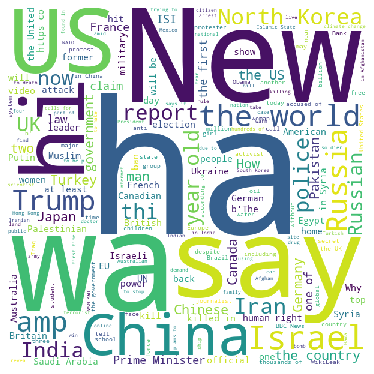

In [13]:
#generate word cloud raw corpus
generate_word_graph(word_corpus)

### Word frequency for raw corpus

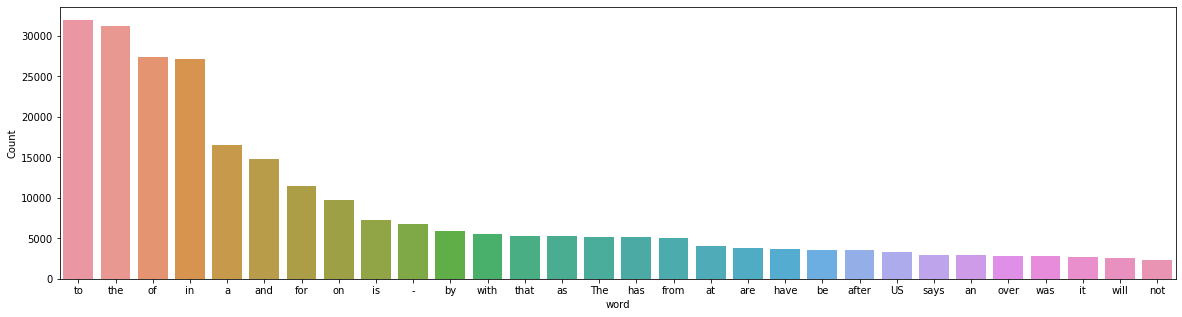

In [14]:
freq_words(words)

### Word cloud for processed text corpus

In [15]:
#generate word cloud after data clean by decontraction  , removing stopwords and junk character and considering only ascii values 

In [16]:
def clean_text(text): 
    
        
    
        text = ''.join([i if ord(i) < 128 else ' ' for i in text])        
        text = text.lower()    
        tokens = text.split()

        phrase = " ".join(str(x) for x in tokens)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # remove general decontractions 
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase) 
        
        # remove chars other than  alpha numeric
        cln_txt = re.sub(r'&amp;', '', phrase) 
        cln_txt = re.sub(r'0,0', '00', cln_txt) 
        cln_txt = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', cln_txt)
        cln_txt = re.sub(r'\'', ' ', cln_txt)
        cln_txt = re.sub(r'\$', ' $ ', cln_txt)
        
        text = re.sub(r'&amp;', '', cln_txt) 
        text = re.sub(r'0,0', '00', text) 
        text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
        text = re.sub(r'\'', ' ', text)
        text = re.sub(r'\$', ' $ ', text)
        text = re.sub(r'u s ', ' united states ', text)
        text = re.sub(r'u n ', ' united nations ', text)
        text = re.sub(r'u k ', ' united kingdom ', text)
        text = re.sub(r'j k ', ' jk ', text)
        text = re.sub(r' s ', ' ', text)
        text = re.sub(r' yr ', ' year ', text)
        text = re.sub(r' l g b t ', ' lgbt ', text)
        text = re.sub(r'0km ', '0 km ', text)    
        text = re.sub(r'[^\x00-\x7f]',r'', text)
        text = text.replace(' ha ','').replace(' wa ','').replace(' aa ','')
        
        # Remove stop words
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops and len(w) > 1]
    
        text = " ".join(text)       
        
    
        return text

In [17]:
# create news corpus
merged_headlines = []
for daily_headlines in headlines:
    merge_daily_headlines = []
    for headline in daily_headlines:
        merge_daily_headlines.append(clean_text(headline))
    merged_headlines.append(merge_daily_headlines)

In [18]:
# Create the word vocab
import collections
words = [word for headlines in merged_headlines for headline in headlines for word in headline.split()]
word_counts = collections.Counter(words)
words = " ".join(words)

In [19]:
merged_headlines_arr = [' '.join(merged_headline) for merged_headline in merged_headlines]
word_corpus = ' '.join(merged_headlines_arr)

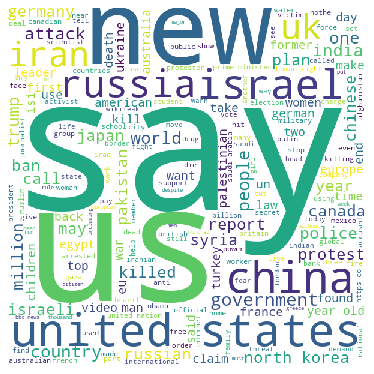

In [20]:
#generate word cloud for formatted  corpus
generate_word_graph(word_corpus)

### word frequency for processed text corpus

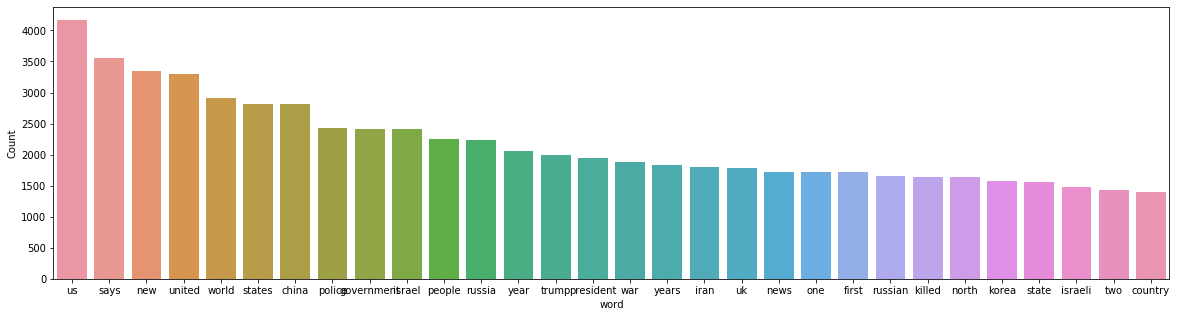

In [21]:
freq_words(words)

In [22]:
### Cleaning data after doing stopword removal,non-ascii char contaning word removal,decontraction had visible impact on word cloud and word frequency
### as clear from the graphs

### Topic Modelling for processed corpus

In [23]:
# Let's now build the topic model. We'll define 10 topics to start with.
# The hyperparameter alpha affects sparsity of the document-topic (theta) distributions, 
# whose default value is 1.Similarly, the hyperparameter eta can also be specified, which affects the topic-word distribution's sparsity.

In [24]:
pyLDAvis.enable_notebook()

In [25]:
def lemmatization(text, tags=['NOUN', 'PROPN','ADJ','VERB']):  
    output = []
    doc = nlp(text) 
    output.append([token.lemma_ for token in doc if token.pos_ in tags])
    opstr = ' '.join(w for w in output[0]) 
    
    return opstr

def prepare_topic_vocab(headline_lst):

    headline_lst = [x for x in headline_lst]   
    
    headline_lst = [headline.split(' ') for headline in headline_lst]
    # Create the term dictionary of our corpus, where every unique term is assigned an index
    dictionary = corpora.Dictionary(headline_lst)    
    # Convert list of reviews  into a Document Term Matrix using the dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(headl) for headl in headline_lst]   
    
    corpus = [dictionary.doc2bow(text) for text in headline_lst]    
    # Creating the object for LDA model using gensim library
    

    return corpus,doc_term_matrix,dictionary,headline_lst

In [26]:
# #do topic modelling
# vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)

In [27]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))

    return model_list, coherence_values

In [28]:
# build models across a range of num_topics and alpha
corpus,doc_term_matrix,dictionary,texts = prepare_topic_vocab(merged_headlines_arr)

num_topics_range = [2, 5, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [29]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df = coherence_df.sort_values(by=['coherence_value'],ascending = False)

In [30]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.1, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)


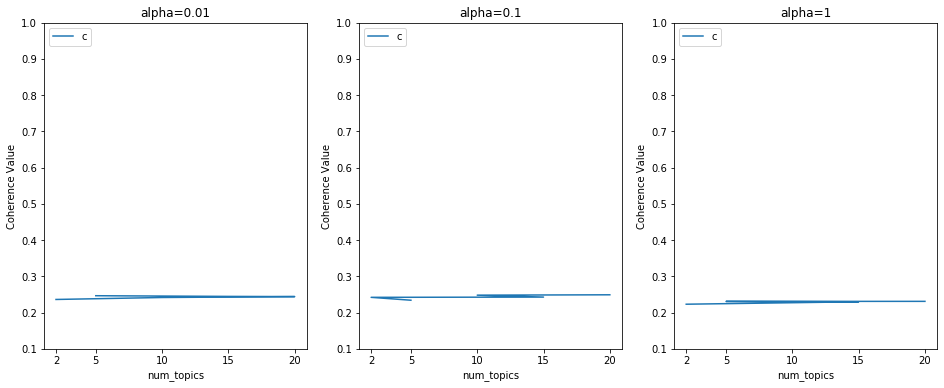

In [31]:
plot_coherence(coherence_df, alpha_range, num_topics_range)

In [32]:
#looking at the distribution of data though coherence values are highest for 2 topic and alpha  0.01,
# we are choosing 10 topics with alpha 0.01

In [33]:
LdaMulticore = gensim.models.LdaMulticore
    
num_topics = 5
alpha = 0.01
# Build LDA model with alpha=<alpha> and <n> topics
lda_model = LdaMulticore(  corpus=corpus,
                           id2word=dictionary,
                           num_topics=num_topics, 
                           alpha=alpha,
                           per_word_topics=True,
                           random_state=100,
                           chunksize=1000,
                            passes=50)

In [34]:
# print keywords 
pprint.pprint(lda_model.print_topics())

[(0,
  '0.005*"us" + 0.002*"nothe" + 0.002*"world" + 0.002*"israel" + '
  '0.002*"israeli" + 0.002*"uk" + 0.002*"police" + 0.002*"man" + 0.002*"one" + '
  '0.002*"people"'),
 (1,
  '0.005*"us" + 0.004*"new" + 0.004*"says" + 0.004*"united" + 0.004*"china" + '
  '0.004*"israel" + 0.004*"government" + 0.004*"world" + 0.004*"police" + '
  '0.003*"people"'),
 (2,
  '0.006*"says" + 0.006*"russia" + 0.004*"united" + 0.004*"russian" + '
  '0.004*"states" + 0.004*"ukraine" + 0.004*"new" + 0.004*"world" + '
  '0.004*"isis" + 0.004*"us"'),
 (3,
  '0.006*"us" + 0.004*"iran" + 0.004*"united" + 0.004*"war" + 0.004*"says" + '
  '0.004*"new" + 0.004*"states" + 0.003*"wikileaks" + 0.003*"world" + '
  '0.003*"israel"'),
 (4,
  '0.017*"trump" + 0.008*"" + 0.005*"says" + 0.005*"us" + 0.005*"news" + '
  '0.004*"https" + 0.004*"new" + 0.004*"united" + 0.004*"//t" + '
  '0.004*"coronavirus"')]


In [35]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.011502  0.072323       1        1  63.966156
4     -0.114386 -0.072405       2        1  13.386226
2     -0.011609  0.052668       3        1  12.009555
3      0.030569  0.015924       4        1   7.910766
0      0.106928 -0.068510       5        1   2.727293, topic_info=            Term         Freq        Total Category  logprob  loglift
1639       trump  1821.000000  1821.000000  Default  30.0000  30.0000
169           us  3951.000000  3951.000000  Default  29.0000  29.0000
35351              819.000000   819.000000  Default  28.0000  28.0000
136         says  3387.000000  3387.000000  Default  27.0000  27.0000
180        world  2770.000000  2770.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
513    president    25.743807  1852.373169   Topic5  -6.7365  -0.6742
101          new    27.682726  3214.570068   Topic5  -6.6639  -1.1528
136         says    27.920788  3387.332520   Topic5  -6.6553  -1.1966
499      million    22.125473  1098.105591   Topic5  -6.8879  -0.3028
924      british    21.557024   965.519348   Topic5  -6.9140  -0.2001

[443 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
35351      2  0.998846        
35352      2  0.998637     //t
2822       1  0.311833      19
2822       2  0.639907      19
2822       3  0.012993      19
...      ...       ...     ...
185        3  0.110461   years
185        4  0.061679   years
185        5  0.017943   years
11525      4  0.836950  zelaya
11525      5  0.083695  zelaya

[896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

In [36]:
### The observation from tpoic modelling is not reliable as all the coherent scores in topic /alpha combinations are less than 0.3
### Hence Topic modelling using LDA technique did not had any impact on our analaysis